In [109]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics.cluster import adjusted_rand_score

from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

import pickle

from scipy.sparse import csr_matrix

import time

In [2]:
def df2array(df):
    # 将数据以 ndarray 的形式读入内存
    # [[x1,x2,...,x500,y1,y2,...,y500],[],...]
    i = 0
    data = np.array([])
    while i <= len(df)-1:
        arrX = np.array(df['x'][i:i+POINTS_NUM_PER_TR])
        arrY = np.array(df['y'][i:i+POINTS_NUM_PER_TR])
        arr = np.append(arrX,arrY)
        if len(data)==0:
            data = np.array([arr])
        else:
            data = np.append(data,[arr],axis=0)
        i+=POINTS_NUM_PER_TR
    return data

## 1 局部聚类，得到子簇

In [3]:
# 确保定义的距离是有效的，非负性，同一性，对称性，直递性（三角不等式）

def dist(tr1,tr2):
    length = len(tr1)
    if not(length == 1000):
        # 传入参数形式为(k,1000)
        # 计算k个簇心点更新前后的距离
        distance = 0
        for i in range(length):
            pre = tr1[i]
            now = tr2[i]
            half = int(len(pre)/2)
            x1 = pre[0:half]
            y1 = pre[half:]
            x2 = now[0:half]
            y2 = now[half:]
            deta_x = x1 - x2
            deta_y = y1 - y2
            distance = distance + np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
    else:       
        half = int(length/2)
        x1 = tr1[0:half]
        y1 = tr1[half:]
        x2 = tr2[0:half]
        y2 = tr2[half:]
        deta_x = x1 - x2
        deta_y = y1 - y2
        distance = np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
        # print(distance)
    return distance

In [4]:
def cluster(data,K):

    metric = distance_metric(type_metric.USER_DEFINED, func=dist)
    initial_centers = kmeans_plusplus_initializer(data, K).initialize()

    kmeans_instance = kmeans(data, initial_centers, metric=metric)

    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    centers = kmeans_instance.get_centers()
    
    return clusters,centers

In [30]:
# ndarray中每个元素长度要相等
# 返回ndarray格式
def getKmeansResult(data,K):
    clusters,centers = cluster(data,K)
    num_tr = len(data)
    labels = np.zeros(num_tr)
    for i in range(K):
        for j in range(num_tr):
            if j in clusters[i]:
                labels[j] = i
    return labels,np.array(centers)

In [7]:
def stableKeanmsClustering(data,k):
    labels,centers = getKmeansResult(data,k)
    min_cost = cost(data,labels,centers)
    for i in range(50): # 取50次聚类中损失函数最小的
        labels_,centers_ = getKmeansResult(data,k)
        cost_ = cost(data,labels_,centers_)
        if cost_ < min_cost:
            labels = labels_
            centers = centers_
            min_cost = cost_
    print('min_cost:'+str(min_cost))
    return labels,centers

In [28]:
def cost(data,labels,centers):
    loss = 0
    for i in range(len(data)):
        loss = loss + dist(data[i],centers[int(labels[i])])
    loss = loss / len(data)
    return loss # 平均每个簇的损失

In [9]:
def chooseK(data,K):
    x = np.arange(3,K+1)
    y = np.zeros(len(x))
    for k in range(3,K+1):
        labels,centers = getKmeansResult(data,k)
        y[k-3] = cost(data, labels,centers)
    plt.plot(x,y)
    plt.xlabel('K')
    plt.ylabel('cost')
    plt.grid(True)
    plt.show()

#### 1.1 选择 K 值

#### 1.2 choose K,聚类

### 为什么形成的子簇中的轨迹需要尽可能拥有相同的走势？
- 假设形成的某一个子簇中的轨迹有着大程度上的不同走势：轨迹A和轨迹B若存在点交叉的部分（这是大概率会发生的事情），而此时假设轨迹A和轨迹B的走势完全不同，则在交叉点之前可能是A走势，交叉点后有可能会按照B走势进行，这样生成的轨迹是不包含在这个子簇分布里面的。
- 如果子簇中的大部分轨迹走势类似，则在交叉点前后是同一走势，不会生成不符合子簇分布的轨迹。

## 2 网格化矩阵

In [10]:
def discretization(data):
    
    # 网格坐标化
    data = np.round(data)
    tr_point = [    [  (data[j][i],data[j][i+POINTS_NUM_PER_TR])    for i in range(POINTS_NUM_PER_TR)]     
                           for j in range(len(data))]
    
    
    # 去掉连续落在同一区间上的点
    for i in range(len(tr_point)):
        tmp = []
        l = tr_point[i].copy()
        for j in range(POINTS_NUM_PER_TR-1):
            if l[j] == l[j+1]:
                tmp.append(j)
        tr_point[i] = [l[i] for i in range(POINTS_NUM_PER_TR) if i not in tmp]
        
    # 防止出现跨越的点
    for i in range(len(tr_point)):
        tmp = tr_point[i].copy()  # [(),(),...,()]
        count = 0 # 添加的点造成的偏移
        for j in range(len(tmp) - 1):
            now_p = tmp[j]
            next_p = tmp[j + 1]
            if not(tr_point[i][j + count] == now_p and tr_point[i][j + count + 1] == next_p):
                print('WRONGGGGG: ',now_p,next_p,tr_point[i][j + count],tr_point[i][j + count],)
                break
            if now_p[0] == next_p[0] and abs(now_p[1] - next_p[1]) == 1:
                continue
            elif abs(now_p[0] - next_p[0]) == 1 and now_p[1] == next_p[1]:
                continue   
            else:
                # print(now_p,next_p)
                delta_x = int(abs(now_p[0] - next_p[0]))
                delta_y = int(abs(now_p[1] - next_p[1]))
                if delta_x == 0:
                    step = (next_p[1] - now_p[1]) / delta_y
                    for k in range(1,delta_y,1):
                        tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                    count = count + delta_y - 1
                    continue
                elif delta_y == 0:
                    step = (next_p[0] - now_p[0])/delta_x
                    for k in range(1,delta_x,1):
                        tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                    count = count + delta_x - 1
                    continue
                else:
                    step_x = (next_p[0] - now_p[0])/delta_x
                    step_y = (next_p[1] - now_p[1]) / delta_y
                    k = 1
                    while delta_x != 0 and delta_y != 0:
                        tr_point[i].insert(j + count + 1,(now_p[0] + k * step_x,now_p[1]))
                        tr_point[i].insert(j + count + 2,(now_p[0] + k * step_x,now_p[1] + k * step_y))
                        count = count + 2
                        k = k + 1
                        delta_x = delta_x - 1
                        delta_y = delta_y - 1
                    if delta_x == 0 and delta_y == 0:
                        tr_point[i].pop(j + count)
                        count = count - 1
                    elif delta_x == 0:
                        step = (next_p[1] - now_p[1]) / delta_y
                        for k in range(1,delta_y,1):
                            tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                        count = count + delta_y - 1
                        continue
                    elif delta_y == 0:
                        step = (next_p[0] - now_p[0])/delta_x
                        for k in range(1,delta_x,1):
                            tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                        count = count + delta_x - 1
                        continue
                        
    return tr_point

## 3 生成模型

In [61]:
def checkDiscTr(data):
    for index in range(len(data)):
        tr = data[index]
        for i in range(len(tr)-1):
            nowP = tr[i]
            nextP = tr[i+1]
            if np.abs(nextP[0]-nowP[0])+np.abs(nextP[1]-nowP[1]) > 1:
                print('wroooooooooooooong!!!')
                print(nowP,nextP,index)
            if np.abs(nextP[0]-nowP[0])+np.abs(nextP[1]-nowP[1]) == 0:
                print('wroooooooooooooong!!!')
                print(nowP,nextP,index)

In [62]:
def markovModle(disc_tr,all_point):
    
    checkDiscTr(disc_tr)
    
    prob = np.zeros((len(all_point),len(all_point)))
    trans_matrix = pd.DataFrame(prob,columns = pd.MultiIndex.from_tuples(all_point),  index = pd.MultiIndex.from_tuples(all_point))
    
    for index in range(len(disc_tr)):
        tr = disc_tr[index]
        for j in range(len(tr) - 1):
            now_p = tr[j]
            next_p = tr[j + 1]
            trans_matrix.loc[now_p,next_p] = trans_matrix.loc[now_p,next_p] + 1
            
    for i in range(len(trans_matrix)):
        trans_matrix.iloc[i] = trans_matrix.iloc[i] / sum(trans_matrix.iloc[i])
        
    return trans_matrix.values

In [63]:
def getParaList(labels,k,data):
    paraList = []
    for i in range(k):
        paraDict = {}
        discTr = discretization(data[labels == i]) # list
        
        # 生成轨迹最大长度和最小长度
        maxLength = 0
        for j in discTr:
            if maxLength < len(j):
                maxLength = len(j)
        
        minLength = maxLength
        for j in discTr:
            if minLength > len(j):
                minLength = len(j)
                
        # 初始点集合
        firstPoints = list(np.zeros(len(discTr)))
        for j in range(len(discTr)):
            firstPoints[j] = discTr[j][0]
            
        # 截止点集合
        lastPoints = list(np.zeros(len(discTr)))
        for j in range(len(discTr)):
            lastPoints[j] = discTr[j][-1]   
        lastPoints = list(set(lastPoints))
            
        # 点状态集合
        allState = []
        for n in discTr:
            for j in range(len(n)):
                allState.append(n[j])
        allState = list(set(allState))
        
        # 转移矩阵
        transMat = markovModle(discTr,allState)
        
        paraDict['lastP'] = lastPoints
        paraDict['firstP'] = firstPoints
        paraDict['transM'] = csr_matrix(transMat)
        paraDict['allS'] = allState
        paraDict['minmaxL'] = [minLength,maxLength]
    
        paraList.append(paraDict)
    
    return paraList

In [32]:
def getParaFile(nodeName,k):
    df = pd.read_csv('./data/'+nodeName+'.csv')
    data = df2array(df)
    labels,centers = stableKeanmsClustering(data,k)
    para = getParaList(labels,k,data)
    with open('para/'+nodeName+'paraK'+str(k)+'.pickle', 'wb') as f:
            pickle.dump(para, f, pickle.HIGHEST_PROTOCOL)

In [33]:
POINTS_NUM_PER_TR = 500

In [64]:
getParaFile('node1',3)

min_cost:6.303525789207611


In [84]:
getParaFile('node2',3)

min_cost:5.729118477761299


In [85]:
getParaFile('node3',3)

min_cost:5.736571604971629


In [126]:
getParaFile('node1',6)
getParaFile('node2',6)
getParaFile('node3',6)

min_cost:3.9022990335177994
min_cost:3.7016113865264453
min_cost:3.676208220063651


In [128]:
getParaFile('node1',8)
getParaFile('node2',8)
getParaFile('node3',8)

min_cost:3.2232899391239833
min_cost:3.035204959827278
min_cost:2.925409487934692


In [116]:
getParaFile('node1',10)
getParaFile('node2',10)
getParaFile('node3',10)

min_cost:2.800070745190257
min_cost:2.7467608590233192
min_cost:2.4610323551147517


In [127]:
getParaFile('node1',15)
getParaFile('node2',15)
getParaFile('node3',15)

min_cost:2.1930517776277156
min_cost:2.2119682594546637
min_cost:1.9582713321266954


In [121]:
getParaFile('node1',20)
getParaFile('node2',20)
getParaFile('node3',20)

min_cost:1.8363088626996553
min_cost:1.8999117989109684
min_cost:1.6777665277700158


In [86]:
NODE_NUM = 3

In [110]:
def trGendrator(allPara):
    returnTr = []
    for node in range(NODE_NUM):
        # 每个节点
        nodePara = allPara[node]
        for j in range(len(nodePara)):
            
           
            # 每个子簇
            cPara = nodePara[j]
            
            firstPoints = cPara['firstP']
            lastPoints = cPara['lastP']
            allState = cPara['allS']
            transMatrix = pd.DataFrame(cPara['transM'].A,columns = pd.MultiIndex.from_tuples(allState),  index = pd.MultiIndex.from_tuples(allState))
            minmaxLength = cPara['minmaxL']
            
            minLength = minmaxLength[0]
            maxLength = minmaxLength[1]
            
            for i in range(len(firstPoints)):
                print('第'+str(node+1)+'个节点，第'+str(j+1)+'个子簇，'+'第'+str(i+1)+'条轨迹......')
                # 每条轨迹
                genTr = []
                nowP = firstPoints[i]
                genTr.append(nowP)
                start = time.time()
                while(True):
                    
                    end = time.time()
                    if(end - start > 120): # 如果总是迭代不出来，补救措施
                        
                        df = pd.read_csv('./data/node'+str(node+1)+'.csv')
                        data = df2array(df)
                        disc_data = discretization(data)
                        for trrr in disc_data:
                            if nowP == trrr[0] and len(trrr) > minLength and len(trrr) < maxLength:
                                genTr = trrr
                                break
                        break
                        
                    pro = list(transMatrix.loc[nowP])
                    
                    if np.isnan(pro[0]):
                        if len(genTr) < minLength or len(genTr) > maxLength:
                            #print('1.长度为'+str(len(genTr))+'长度不合适')
                            genTr = []                           
                            nowP = firstPoints[i]
                            genTr.append(nowP)
                            continue
                        else:
                            break
                            
                    n = np.random.choice(len(allState),1,p = pro)
                    nextP = allState[n[0]]
                    
                    # 检查是否生成了不合规的网格点
                    if np.abs(nextP[0]-nowP[0]) + np.abs(nextP[1]-nowP[1]) > 1:
                        print('wroooooooooooooong!!!')
                        print(nowP,nextP,index)
                    if np.abs(nextP[0]-nowP[0]) + np.abs(nextP[1]-nowP[1]) == 0:
                        print('wroooooooooooooong!!!')
                        print(nowP,nextP,index)  
                        print(pro)
                        
                    if nextP in lastPoints:  # 因为有可能是last point，但是概率分布不是nan
                        genTr.append(nextP)
                        if len(genTr) < minLength:
                            nowP = nextP
                            continue
                        elif len(genTr) > maxLength:
                            #print('2.长度为'+str(len(genTr))+'长度不合适')
                            genTr = []
                            nowP = firstPoints[i]
                            genTr.append(nowP)
                            continue
                        else:
                            break
                            
                    genTr.append(nextP)
                    if len(genTr) > maxLength:
                        #print('3.长度为'+str(len(genTr))+'长度不合适')
                        genTr = []                       
                        nowP = firstPoints[i]
                        genTr.append(nowP)
                        continue
                        
                    nowP = nextP
                
                returnTr.append(genTr)
    return returnTr

In [111]:
def loadPara(k):
    allPara = []
    with open('para/node1paraK'+str(k)+'.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    with open('para/node2paraK'+str(k)+'.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    with open('para/node3paraK'+str(k)+'.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    return allPara

In [148]:
GEN_TR = trGendrator(loadPara(15))

第1个节点，第1个子簇，第1条轨迹......
第1个节点，第1个子簇，第2条轨迹......
第1个节点，第1个子簇，第3条轨迹......
第1个节点，第1个子簇，第4条轨迹......
第1个节点，第1个子簇，第5条轨迹......
第1个节点，第1个子簇，第6条轨迹......
第1个节点，第1个子簇，第7条轨迹......
第1个节点，第1个子簇，第8条轨迹......
第1个节点，第1个子簇，第9条轨迹......
第1个节点，第1个子簇，第10条轨迹......
第1个节点，第1个子簇，第11条轨迹......
第1个节点，第1个子簇，第12条轨迹......
第1个节点，第1个子簇，第13条轨迹......
第1个节点，第1个子簇，第14条轨迹......
第1个节点，第1个子簇，第15条轨迹......
第1个节点，第1个子簇，第16条轨迹......
第1个节点，第1个子簇，第17条轨迹......
第1个节点，第1个子簇，第18条轨迹......
第1个节点，第1个子簇，第19条轨迹......
第1个节点，第1个子簇，第20条轨迹......
第1个节点，第1个子簇，第21条轨迹......
第1个节点，第1个子簇，第22条轨迹......
第1个节点，第1个子簇，第23条轨迹......
第1个节点，第1个子簇，第24条轨迹......
第1个节点，第1个子簇，第25条轨迹......
第1个节点，第1个子簇，第26条轨迹......
第1个节点，第1个子簇，第27条轨迹......
第1个节点，第1个子簇，第28条轨迹......
第1个节点，第1个子簇，第29条轨迹......
第1个节点，第1个子簇，第30条轨迹......
第1个节点，第1个子簇，第31条轨迹......
第1个节点，第1个子簇，第32条轨迹......
第1个节点，第1个子簇，第33条轨迹......
第1个节点，第2个子簇，第1条轨迹......
第1个节点，第2个子簇，第2条轨迹......
第1个节点，第2个子簇，第3条轨迹......
第1个节点，第2个子簇，第4条轨迹......
第1个节点，第2个子簇，第5条轨迹......
第1个节点，第2个子簇，第6条轨迹......
第1个节点，第2个子簇，第7条轨迹......
第1个节点，第3个子簇，第1条轨

第2个节点，第14个子簇，第5条轨迹......
第2个节点，第14个子簇，第6条轨迹......
第2个节点，第14个子簇，第7条轨迹......
第2个节点，第14个子簇，第8条轨迹......
第2个节点，第14个子簇，第9条轨迹......
第2个节点，第14个子簇，第10条轨迹......
第2个节点，第14个子簇，第11条轨迹......
第2个节点，第14个子簇，第12条轨迹......
第2个节点，第14个子簇，第13条轨迹......
第2个节点，第14个子簇，第14条轨迹......
第2个节点，第14个子簇，第15条轨迹......
第2个节点，第14个子簇，第16条轨迹......
第2个节点，第14个子簇，第17条轨迹......
第2个节点，第15个子簇，第1条轨迹......
第2个节点，第15个子簇，第2条轨迹......
第2个节点，第15个子簇，第3条轨迹......
第2个节点，第15个子簇，第4条轨迹......
第2个节点，第15个子簇，第5条轨迹......
第2个节点，第15个子簇，第6条轨迹......
第2个节点，第15个子簇，第7条轨迹......
第2个节点，第15个子簇，第8条轨迹......
第3个节点，第1个子簇，第1条轨迹......
第3个节点，第1个子簇，第2条轨迹......
第3个节点，第1个子簇，第3条轨迹......
第3个节点，第1个子簇，第4条轨迹......
第3个节点，第1个子簇，第5条轨迹......
第3个节点，第1个子簇，第6条轨迹......
第3个节点，第1个子簇，第7条轨迹......
第3个节点，第1个子簇，第8条轨迹......
第3个节点，第1个子簇，第9条轨迹......
第3个节点，第1个子簇，第10条轨迹......
第3个节点，第2个子簇，第1条轨迹......
第3个节点，第2个子簇，第2条轨迹......
第3个节点，第3个子簇，第1条轨迹......
第3个节点，第3个子簇，第2条轨迹......
第3个节点，第3个子簇，第3条轨迹......
第3个节点，第3个子簇，第4条轨迹......
第3个节点，第3个子簇，第5条轨迹......
第3个节点，第3个子簇，第6条轨迹......
第3个节点，第3个子簇，第7条轨迹......
第3个节点，第3个子

In [149]:
len(GEN_TR)

532

In [150]:
checkDiscTr(GEN_TR)

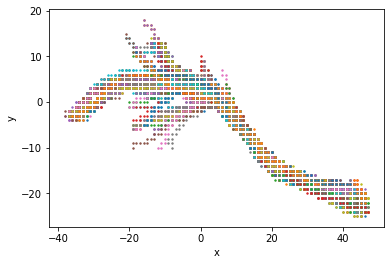

In [151]:
for i in range(len(GEN_TR)):
    x = [p[0] for p in GEN_TR[i]]
    y = [p[1] for p in GEN_TR[i]]
    plt.scatter(x,y,2)
    plt.xlabel('x')
    plt.ylabel('y')
plt.show()

### 中心节点处理方式
- 依据初始点、转移矩阵、状态集合和最大生成长度生成网格化轨迹数据
- 生成的网格化数据进行聚类操作

#### 注意
对比试验的时候，将所有数据进行网格化后，在通过比对簇心来得到标签